# Model Agnostic Methods

Sometimes, the interpretable models just don't cut it and we need to resort a more complex model. This is absolutely normal - complex problems often require complex solutions. However, we still need to be able to verify and validate the model. We need to be able to understand how it works and how it can be manipulated or misused.

This is where model agnostic methods come into play. In this case we can only manipulate the inputs and observe the change in outputs. 

This notebook will cover two methods:
1. Partial Dependence Plots
2. Permutation Feature Importance

Again, please reference https://christophm.github.io/interpretable-ml-book/agnostic.html for a lot more detail and more sophisticated methods.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../data/deputat_daily_features.csv').dropna()
data.head()

,Unnamed: 0,deputat,party,present,date,Year,Month,Week,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,present_last_ass,present_last_5ass
5,5,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-24,2019,1,4,24,3,False,False,False,False,False,False,0.0,0.6
6,6,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-25,2019,1,4,25,4,False,False,False,False,False,False,0.0,0.4
7,7,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-30,2019,1,5,30,2,False,False,False,False,False,False,0.0,0.4
8,8,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-01-31,2019,1,5,31,3,True,False,False,False,False,False,0.0,0.2
9,9,АДЛЕН ШУКРИ ШЕВКЕД,ДПС,False,2019-02-01,2019,2,5,1,4,False,True,False,False,False,False,0.0,0.0


In [18]:



numerical_features = ['present_last_ass', 'present_last_5ass']
categorical_features = ['party']

def prepare_features_df(data):
    features_df = data[numerical_features].copy()

    for cat_feat in categorical_features:
        dummies = pd.get_dummies(data[cat_feat], prefix=cat_feat)
        dummies = dummies.drop(columns=dummies.columns[:1])
        features_df = pd.concat([features_df, dummies],axis=1)
    features_df['bias'] = 1
    return features_df


    
features_df = prepare_features_df(data)

## Train the black box model

To test the methods, we will be using a deep neural network - a 3-layer perceptron. We're using it for illustrative purposes, so we don't need to go overly complex.


In [19]:
from sklearn.neural_network import MLPClassifier

In [20]:
# define the model
model = MLPClassifier(hidden_layer_sizes=(50, 20, 10))

In [21]:
# fit the model
model.fit(features_df.values, data['present'])

MLPClassifier(hidden_layer_sizes=(50, 20, 10))

In [22]:
# score the model
model.score(features_df.values, data['present'])

0.748754081457295

In [23]:
predictions = model.predict_proba(features_df.values)[:,1]

In [24]:
from sklearn.inspection import partial_dependence,plot_partial_dependence
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('notebook')
sns.set_style('white')

In [25]:
before = model.predict_proba(features_df.values).mean()
afters = []
for feat_value in [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1.]:    
    modified_data = data.copy()
    modified_data['present_last_5ass'] = feat_value
    partial_dep_df = prepare_features_df(modified_data)
    after = model.predict_proba(partial_dep_df.values)[:,1].mean()
    afters.append(after)
    
before, afters

(0.5,
 [0.20282333981124948,
  0.27887351498049373,
  0.3697469947314475,
  0.43194968721509097,
  0.49120598614331995,
  0.5481514816150167,
  0.603072809950831,
  0.6596660083172267,
  0.711928179088372,
  0.7590362802501419,
  0.7973791604670964])

(0, 0.8973791604670964)

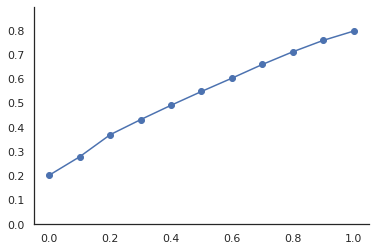

In [26]:
fig, ax = plt.subplots()
sns.despine(fig)
ax.plot([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1.], afters, 'bo-')
ax.set_ylim((0, max(afters) + 0.1))

In [27]:
data.columns

Index(['Unnamed: 0', 'deputat', 'party', 'present', 'date', 'Year', 'Month',
       'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'present_last_ass', 'present_last_5ass'],
      dtype='object')

In [12]:
features_df.columns

Index(['present_last_ass', 'present_last_5ass', 'party_ГЕРБ', 'party_ДПС',
       'party_НЕЗ', 'party_ОП', 'party_ПГБСП', 'bias'],
      dtype='object')

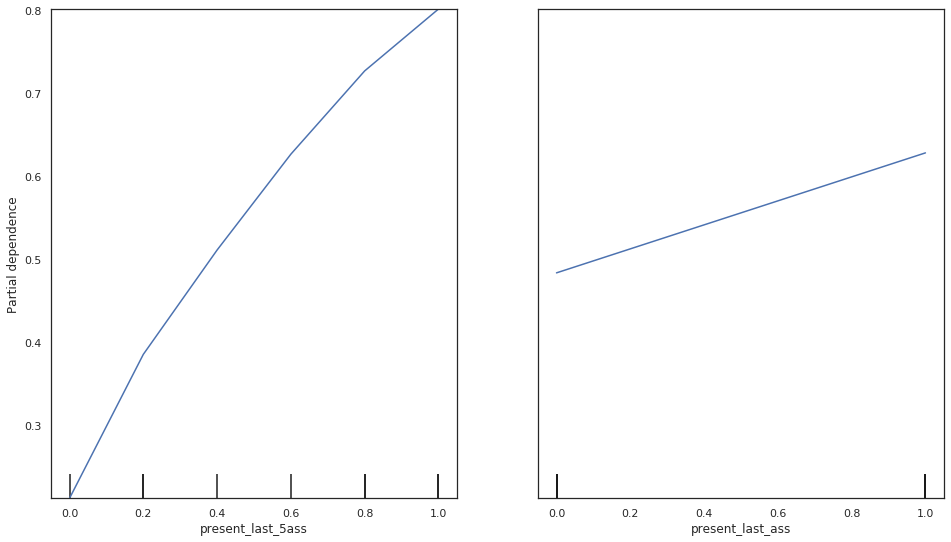

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
plot_partial_dependence(model,features_df.values,feature_names=features_df.columns.tolist(), features=["present_last_5ass", 'present_last_ass'],ax=ax);